In [23]:
#ds.to_netcdf('kextEnv_t_btemp_20230217.nc',encoding={'kext':{'zlib':True,'complevel':5,'dtype':'float32'},
#                                                        't':{'zlib':True,'complevel':5,'dtype':'float32'},
#                                                        'btemp':{'zlib':True,'complevel':5,'dtype':'float32'},
#                                                        'lat':{'zlib':True,'complevel':5,'dtype':'float32'},
#                                                        'lon':{'zlib':True,'complevel':5,'dtype':'float32'}})

import netCDF4 as nc
import numpy as np

with nc.Dataset('kextEnv_t_btemp_20230217.nc','r') as ds:
    kextEnv = ds.variables['kext'][:]
    freqEnv=ds.variables['freq'][:]
    lat=ds.variables['lat'][:]
    lon=ds.variables['lon'][:]
    temp=ds.variables['t'][:]

In [52]:
print(kextEnv.shape)
print(freqEnv)

with nc.Dataset('kextScatProp_hyd_20230217.nc','r') as ds:
    kext_h = ds.variables['kext'][:]
    kscat_h=ds.variables['salb'][:]
    g_h=ds.variables['asym'][:]
    freq_h=ds.variables['freq'][:]
   
print(freq_h)

(6, 80, 123, 105, 7)
[ 94. 170. 180. 182. 336. 328. 326.]
[ 94.   183.31 325.15]


In [27]:
import numpy as np
emis_mean_grid = np.load('/Users/mgrecu/gpm_emis/data/emis_mean_grid_bare.masked.npy')
emis_mean_snow_grid=np.load('/Users/mgrecu/gpm_emis/data/emis_mean_grid_snow.masked.npy')

import matplotlib.pyplot as plt
print(emis_mean_grid.shape)
print(temp.shape)

(12, 560, 1440, 11)
(6, 81, 123, 105)


In [28]:
ny,nx=lon.shape
ifreqE=-1
emis2d=np.zeros((ny,nx))
im=1
for i in range(nx):
    for j in range(ny):
        i0=int((lon[j,i]+180)/0.25)
        j0=int((lat[j,i]+70)/0.25)
        f1=(lon[j,i]+180)/0.25-i0
        f2=(lat[j,i]+70)/0.25-j0
        emis=(1-f1)*(1-f2)*emis_mean_grid[im,j0,i0,ifreqE]+f1*(1-f2)*emis_mean_grid[im,j0,i0+1,ifreqE]+\
                (1-f1)*f2*emis_mean_grid[im,j0+1,i0,ifreqE]+f1*f2*emis_mean_grid[im,j0+1,i0+1,ifreqE]
        emis2d[j,i]=emis
        if emis<0:
            emis=(1-f1)*(1-f2)*emis_mean_snow_grid[im,j0,i0,ifreqE]+f1*(1-f2)*emis_mean_snow_grid[im,j0,i0+1,ifreqE]+\
                (1-f1)*f2*emis_mean_snow_grid[im,j0+1,i0,ifreqE]+f1*f2*emis_mean_snow_grid[im,j0+1,i0+1,ifreqE]
        emis2d[j,i]=emis

/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_86517/2628170014.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon,lat,emis2d,vmin=0.2,vmax=1.0)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_86517/2628170014.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon,lat,xland[0,:,:])


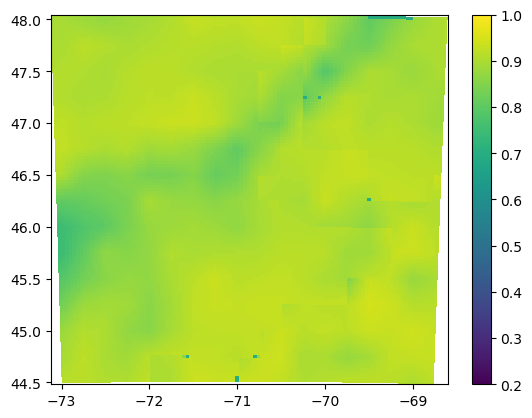

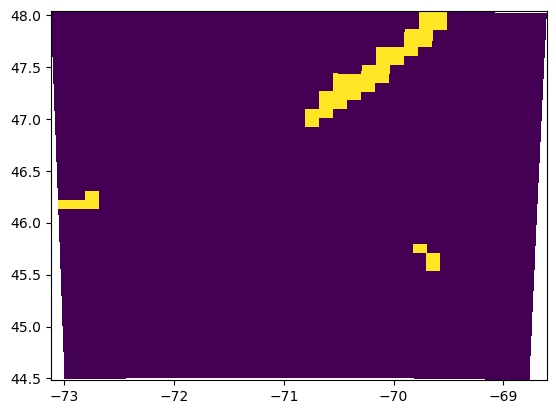

In [30]:
plt.pcolormesh(lon,lat,emis2d,vmin=0.2,vmax=1.0)
emis2d[emis2d<0.7]=0.7
plt.colorbar()
with nc.Dataset('/Users/mgrecu/WDomains/IMPACTS_20230217/wrfout_d02_2023-02-17_01:00:00') as f:
    xland=f.variables['XLAND'][:]

plt.figure()
plt.pcolormesh(lon,lat,xland[0,:,:])


In [55]:
import scatterLib as libSc

umu=np.cos(53/180.0*np.pi)
nz=80
lyrhgt=np.arange(0,nz+1)*0.25
print(freqEnv)
ifreqEnv=[4,5,6]
print(freqEnv[ifreqEnv])
ifreqH=-1
tb2d=np.zeros((ny,nx,len(ifreqEnv)))
for it in range(1):
    for i in range(nx):
        for j in range(ny):
            kext1D=kextEnv[it,:,j,i,ifreqEnv[1]]+kext_h[it,:,j,i,ifreqH]
            salb1D=kscat_h[it,:,j,i,ifreqH].copy()
            asym1D=g_h[it,:,j,i,ifreqH].copy()
        
            emis=emis2d[j,i]
            fisot=2.7
            ebar=emis
            a=np.nonzero(salb1D>1e-5)
            asym1D[a]=asym1D[a]/salb1D[a]
            salb1D[a]/=kext1D[a]
            tbout=libSc.radtran(umu,temp[it,0,j,i],temp[it,:,j,i],lyrhgt,kext1D,salb1D,asym1D,\
                            fisot,emis,ebar)
            tb2d[j,i,:]=tbout
#tbout=libSc.radtran(umu,temp[0,j,i],temp[:,j,i],lyrhgt,kext[:,j,i,ifreq],salb[:,j,i,ifreq],asym[:,j,i,ifreq],\
#                            fisot,emis,ebar)
            #break
        #break

[ 94. 170. 180. 182. 336. 328. 326.]
[336. 328. 326.]


233.67771911621094
[2.92906046e+00 3.27294278e+00 4.22929716e+00 4.73017216e+00
 4.59479427e+00 4.21580219e+00 3.85566473e+00 3.55199933e+00
 3.31723523e+00 3.10072088e+00 2.86494350e+00 2.54644513e+00
 2.20162034e+00 1.83786857e+00 1.51538944e+00 1.21558952e+00
 9.54328537e-01 7.66336799e-01 6.20499611e-01 5.59961438e-01
 5.32660246e-01 5.24483860e-01 4.96450424e-01 4.58487034e-01
 4.11822587e-01 3.66800368e-01 3.22348297e-01 2.78473318e-01
 2.35934898e-01 1.96493000e-01 1.60345286e-01 1.32091567e-01
 1.08485311e-01 8.85640457e-02 7.29069635e-02 6.04078844e-02
 4.96874079e-02 4.04804423e-02 3.28113139e-02 2.57134233e-02
 1.93546563e-02 1.42240832e-02 1.05237355e-02 7.73364119e-03
 5.70943207e-03 4.26554866e-03 3.18108499e-03 2.20166543e-03
 1.41702930e-03 9.52107017e-04 8.18411703e-04 7.41380267e-04
 6.94552262e-04 6.55102194e-04 6.02818502e-04 5.57947147e-04
 5.19004418e-04 4.85049270e-04 4.52232402e-04 4.21303557e-04
 3.92326940e-04 3.65573243e-04 3.41369334e-04 3.19040089e-04
 2.98

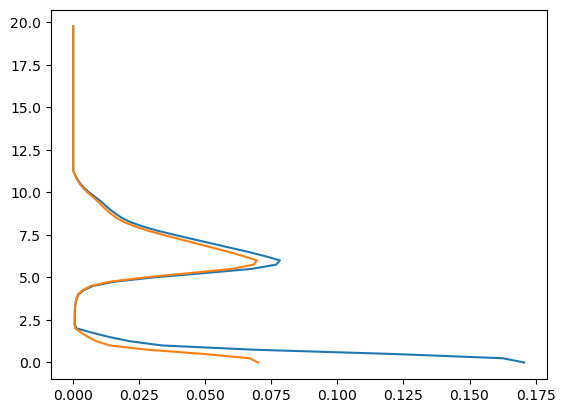

In [54]:
print(tbout)
print(kext1D)
plt.plot(kext_h[it,:,j,i,ifreqH],lyrhgt[:-1])
plt.plot(kscat_h[it,:,j,i,ifreqH],lyrhgt[:-1])

/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


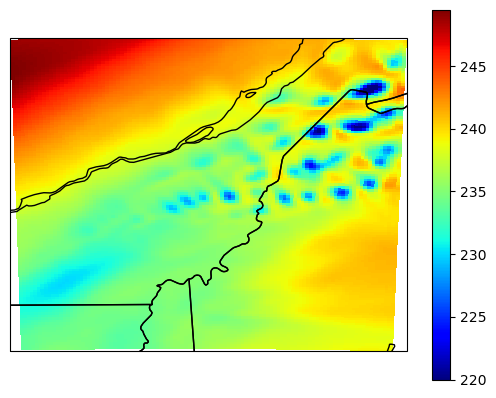

In [58]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon,lat,tb2d[:,:,0],cmap='jet',vmin=220)
# plot states with boundaries
ax.add_feature(cfeature.STATES)
plt.colorbar()
#print(tb2d)

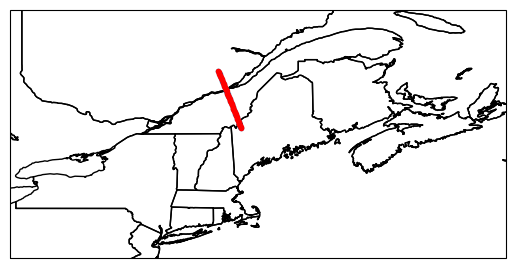